Test and Validation loops in machine learning are useful since they help us to avoid overfitting to the training set.

Pytorch Lightning provides a simple way to add a validation loop to our training loop.

In [1]:
# get the data and split into train and test
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms
import os
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import lightning.pytorch as pl

pl.seed_everything(42)

Global seed set to 42


42

In [2]:
# load data
transform = transforms.ToTensor()
train_set = datasets.MNIST(root='MNIST', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='MNIST', train=False, download=True, transform=transform)

In [3]:
# continueing from level 1 we define the autoencoder
encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 16))
decoder = nn.Sequential(nn.Linear(16, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder, learning_rate=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        # The LightningModule allows you to automatically save all the hyperparameters passed to init simply by calling
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        # training step defines the train loop
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    # here we define the test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("test_loss", loss)
        return loss
    
    # here we define the validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer
    
# model hyperparameters can then be accessed via
checkpoint = torch.load("./model_with_hparams.ckpt", map_location=lambda storage, loc: storage)
print(checkpoint["hyper_parameters"])

# can also load the model directly
model = LitAutoEncoder.load_from_checkpoint("./model_with_hparams.ckpt")
print(model.learning_rate)

{'encoder': Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=16, bias=True)
), 'decoder': Sequential(
  (0): Linear(in_features=16, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=784, bias=True)
), 'learning_rate': 0.0001}
0.0001


c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
  rank_zero_warn(
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\utilities\parsing.py:196: UserWarning: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
  rank_zero_warn(


In [4]:
train_set_size = int(len(train_set) * 0.8)
val_set_size = len(train_set) - train_set_size

train_set, val_set = data.random_split(train_set, [train_set_size, val_set_size])

# create data loaders
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False)

In [5]:
# simply by using the Trainer you get automatic checkpointing
trainer = pl.Trainer(max_epochs=3)
# saves checkpoints to 'some/path/' at every epoch end
# trainer = Trainer(default_root_dir="some/path/")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
new_model = LitAutoEncoder(encoder, decoder, learning_rate=1e-4)

In [7]:
# train with validation loop
# trainer.fit(new_model, train_loader, val_loader)

# automatically restores model, epoch, step, LR schedulers, etc...
# trainer.fit(model, ckpt_path="some/path/to/my_checkpoint.ckpt")

In [8]:
# now test
trainer.test(new_model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.12101256102323532    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.12101256102323532}]

In [9]:
# save the model
trainer.save_checkpoint("model_with_hparams.ckpt")

In [10]:
import matplotlib.pyplot as plt

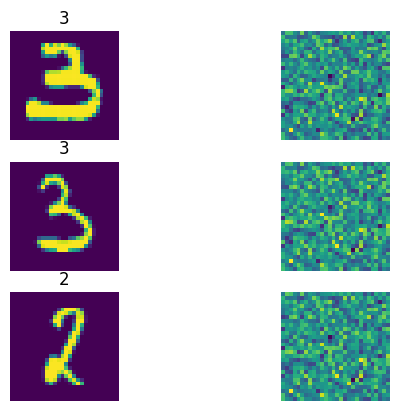

In [11]:
# again, lets get an idea of how the model does
# lets see how it does
enc = new_model.encoder
enc.eval()
dec = new_model.decoder
dec.eval()

# pick 3 random images, show the original and the enc_dec version side by side in a 3x2 grid
fig, ax = plt.subplots(3, 2)
for i, j in enumerate(np.random.randint(0, len(val_set), 3)):
    ax[i, 0].imshow(val_set[j][0].squeeze())
    ax[i, 0].set_title(val_set[j][1])
    ax[i, 0].axis("off")
    x = val_set[j][0].view(1, -1)
    z = enc(x)
    x_hat = dec(z)
    ax[i, 1].imshow(x_hat.detach().numpy().reshape(28, 28))
    ax[i, 1].axis("off")

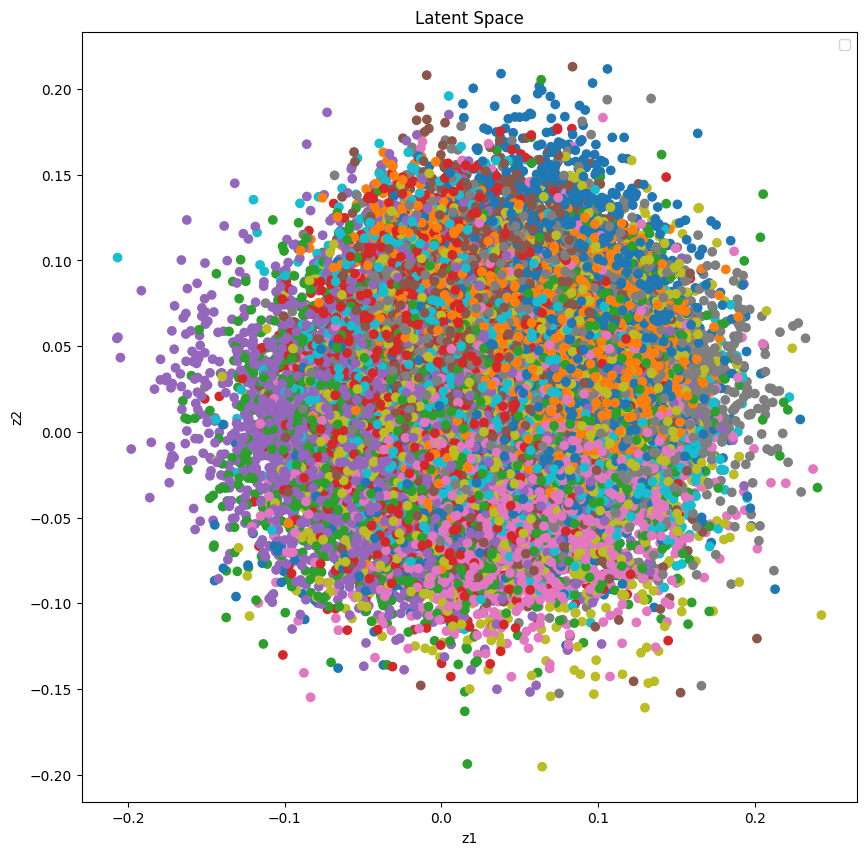

In [12]:
# lets see what the latent space looks like

# get all the latent vectors
all_z = []
all_y = []
for x, y in train_loader:
    x = x.view(x.size(0), -1)
    z = enc(x)
    all_z.append(z)
    all_y.append(y)

all_z = torch.cat(all_z, dim=0).detach().numpy()
all_y = torch.cat(all_y, dim=0).detach().numpy()

# plot the latent vectors
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(all_z[:, 0], all_z[:, 1], c=all_y, cmap="tab10")
ax.set_xlabel("z1")
ax.set_ylabel("z2")
ax.set_title("Latent Space")
# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [str(i) for i in range(10)])
plt.show()

In [13]:
from lightning.pytorch.callbacks import EarlyStopping

# early stopping is also handled effortlessly with callbacks

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[early_stop_callback]
)

# now we can train with early stopping
# trainer.fit(new_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# this improved at every step, had this not been the case, training would have stopped early

In [16]:
# managing experiments
from dotenv import load_dotenv
import os
load_dotenv("../../")

from lightning.pytorch.loggers.wandb import WandbLogger

comet_logger = WandbLogger(project="MNIST", log_model="all")
trainer = pl.Trainer(max_epochs=10, logger=comet_logger)
trainer.fit(new_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 102 K 
1 | decoder | Sequential | 103 K 
---------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.823     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benja\.pyenv\pyenv-win\versions\3.10.9\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
